# Defining and calculating data quality scores

Our approach here is similar to the score assignment system used by Charity Navigator, which calculates multiple subscores before assigning an overall grade based on the euclidean distance from the ideal perfect score.  Each of these scores can range between 0 and 100.  This method has two advantages.  First, users in the aid and philanthropy world tend to already have an understanding of how Charity Navigator scores are assigned, so by mirroring certain elements of their composition we're able to simplify understanding of the metrics that we create.  Second, the 0-100 numeric scale lends itself well to a letter-grade assignment (A-F), which is another concept that's widely understood.

Specific weights and cutoff are set based on a combination of domain expertise and EDA results. There will likely need to be tweaks made as we finalize our MVP, but initial results look promising.

### Setup

In [1]:
%matplotlib inline

In [2]:
from __future__ import division, print_function

import pickle
import os
from datetime import datetime

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from pandas.io.json import json_normalize
import pymongo

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import nltk
from nltk.corpus import words

In [3]:
pd.set_option('display.max_columns', None)

In [4]:
conn=pymongo.MongoClient('mongodb', 27017)

# Check database names to test connection and see what's here
conn.database_names()
db = conn.iati
db.collection_names()

['cleaned_orgs_full',
 'quality',
 'transactions',
 'organizations_metadata',
 'organizations',
 'activities',
 'scores',
 'activities_metadata']

In [5]:
orgs=db.cleaned_orgs_full

In [6]:
orgs.count()

370

In [7]:
import pickle
with open("lookup_by_ref.pickle",'rb') as f:
    lookup=pickle.load(f)

In [8]:
#Load mongo data into pandas dataframe to make EDA easier.
#We'll need this to figure out where to set different cutoffs in our score definitions
df=json_normalize(list(orgs.find()))
df.head()

,_id,benford_compliance.budget,benford_compliance.budget_distribution.0,benford_compliance.budget_distribution.1,benford_compliance.budget_distribution.2,benford_compliance.budget_distribution.3,benford_compliance.budget_distribution.4,benford_compliance.budget_distribution.5,benford_compliance.budget_distribution.6,benford_compliance.budget_distribution.7,benford_compliance.budget_distribution.8,benford_compliance.budget_distribution.9,benford_compliance.transaction,benford_compliance.transaction_distribution.0,benford_compliance.transaction_distribution.1,benford_compliance.transaction_distribution.2,benford_compliance.transaction_distribution.3,benford_compliance.transaction_distribution.4,benford_compliance.transaction_distribution.5,benford_compliance.transaction_distribution.6,benford_compliance.transaction_distribution.7,benford_compliance.transaction_distribution.8,benford_compliance.transaction_distribution.9,doc_size.avg,doc_size.max,doc_size.min,missing_data.@default-currency,missing_data.@xml:lang,missing_data.activity-date,missing_data.budget,missing_data.description,missing_data.document-link,missing_data.participating-org,missing_data.result,missing_data.title,missing_data.transaction,organization_id,organization_name,records,relative_size.budget,relative_size.description,relative_size.document-link,relative_size.participating-org,relative_size.result,relative_size.title,relative_size.transaction,title_description_similarity
0,5a4950a26f8487050240e0e8,0.5,0.0,50.0,12.500000,0.000000,0.000000,0.000000,12.5,25.0,0.0,0.0,1.0,0.0,41.770,36.773333,4.443333,0.0,2.673333,2.223333,0.0,7.116667,5.0,22893.000000,27332,16825,0.0,0.0,0.0,0.333333,0.0,0.000000,0.0,1.0,0.0,0.0,GB-CHC-1112734,DFID Q3 payment,3,0.017520,0.021021,0.016916,0.012006,0.000000,0.007494,0.799967,0.379468
1,5a4950a26f8487050240e0e9,0.5,0.0,50.0,16.666667,8.333333,16.666667,8.333333,0.0,0.0,0.0,0.0,NaN,0.0,0.000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.0,10915.833333,23348,2778,0.0,0.0,0.0,0.000000,0.0,0.916667,0.0,1.0,0.0,1.0,ZA-CIPC-2001/005850/08,GENDER LINKS,12,0.039181,0.740021,0.000803,0.035881,0.000000,0.016305,0.000000,0.271854
2,5a4950a26f8487050240e0ea,0.0,0.0,0.0,0.000000,100.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,1.0,0.0,33.330,33.330000,33.330000,0.0,0.000000,0.000000,0.0,0.000000,0.0,5055.000000,5055,5055,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,1.0,0.0,0.0,GB-CHC-228248,Bond,1,0.054006,0.050841,0.161227,0.074382,0.000000,0.025717,0.373887,0.115281
3,5a4950a26f8487050240e0eb,0.0,0.0,0.0,0.000000,0.000000,83.333333,16.666667,0.0,0.0,0.0,0.0,NaN,0.0,0.000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.0,6387.333333,7518,5644,0.0,0.0,0.0,0.000000,0.0,1.000000,0.0,0.0,0.0,1.0,US-EIN-46-3668128,Women’s Refugee Commission,6,0.043080,0.052098,0.000000,0.051770,0.430744,0.021579,0.000000,0.380640
4,5a4950a26f8487050240e0ec,0.0,0.0,0.0,0.000000,0.000000,0.000000,100.000000,0.0,0.0,0.0,0.0,0.0,0.0,2.085,72.915000,0.000000,0.0,0.000000,0.000000,25.0,0.000000,0.0,19490.000000,32508,6472,0.0,0.0,0.0,0.500000,0.0,1.000000,0.0,1.0,0.0,0.0,GB-CHC-1055436,FY2015-16 4/4: Jan to Mar 2016 PPA Strategic F...,2,0.004230,0.111361,0.000000,0.067909,0.000000,0.012521,0.727883,0.256633


### Definition of different sub-scores

In [9]:
test=orgs.find_one({'organization_id':'21032'})
test

{'_id': ObjectId('5a4950b46f8487050240e253'),
 'benford_compliance': {'budget': 0.2692307692307692,
  'budget_distribution': {'0': 0.591715976331361,
   '1': 26.923076923076923,
   '2': 18.34319526627219,
   '3': 12.721893491124261,
   '4': 10.946745562130177,
   '5': 8.875739644970414,
   '6': 6.508875739644971,
   '7': 5.9171597633136095,
   '8': 3.5502958579881656,
   '9': 5.621301775147929},
  'transaction': 0.25443786982248523,
  'transaction_distribution': {'0': 4.733727810650888,
   '1': 25.443786982248522,
   '2': 16.272189349112427,
   '3': 11.242603550295858,
   '4': 10.946745562130177,
   '5': 8.579881656804734,
   '6': 7.396449704142012,
   '7': 5.325443786982248,
   '8': 4.437869822485207,
   '9': 5.621301775147929}},
 'contact_info': {},
 'doc_size': {'avg': 2088.701183431953, 'max': 4934, 'min': 1576},
 'missing_data': {'@default-currency': 0.0,
  '@xml:lang': 0.0,
  'activity-date': 0.0,
  'budget': 0.0,
  'description': 0.0,
  'document-link': 1.0,
  'participating-org

In [10]:
def calculate_completeness(org):
    """
    10 points per category based on completeness of 10 categories
    proportional to percent of activities with data
   
    Example: If all fields are 100% complete except for one, which is only complete in 50% of documents,
    the resulting score will be 95/100
    """
    score=100
    for i in org['missing_data']:
        score-=org['missing_data'][i]*10
    return int(score)

calculate_completeness(test)

79

In [11]:
def calculate_compliance_old(org):
    """
    -25 points per category for non compliance
    -30 if it’s because there’s no data (this kinda horns in on the completeness as well)
    """
    score=100
    for i in org['benford_compliance']:
        if org['benford_compliance'][i]==0:
            score-=25
        elif not org['benford_compliance'][i]:
            score-=30
    return int(score)

def calculate_compliance(org):
    """
    For both categories (budget and transactions):
    percent of records complying with benfords law*50
   
    Examples:
    if both budgets and transactions fully comply, score will be 100
    if budget fully complies and transactions complies half the time, score will be 75
    """
    score=100
    comp=org.get('benford_compliance')
    if not comp:
        return 0
    for i in comp:
        if not i.endswith('_distribution'):
            score-=50-80*(comp[i] or 0)
    if score>100:
        score=100
    return int(score)
           
calculate_compliance(test)

41

To figure out the right parameters for our document size, we'll need to understand the overall distribution

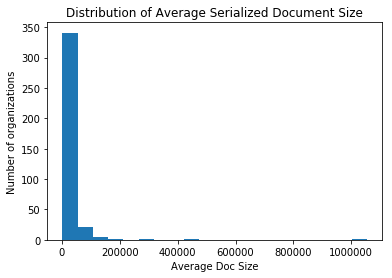

In [12]:
#figure out distribution of sizes
plt.hist(df['doc_size.avg'], bins=20)
plt.title("Distribution of Average Serialized Document Size")
plt.xlabel("Average Doc Size")
plt.ylabel("Number of organizations")
plt.show()

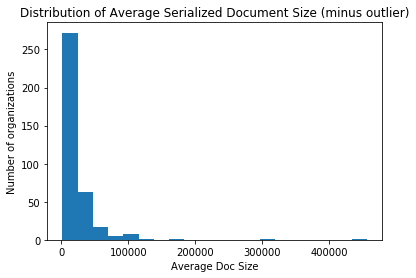

In [13]:
#Replot without the crazy high outlier
outlier=df.iloc[df['doc_size.avg'].idxmax()]['organization_id']
filtered=df[df['organization_id'] != outlier]
plt.hist(filtered['doc_size.avg'], bins=20)
plt.title("Distribution of Average Serialized Document Size (minus outlier)")
plt.xlabel("Average Doc Size")
plt.ylabel("Number of organizations")
plt.show()

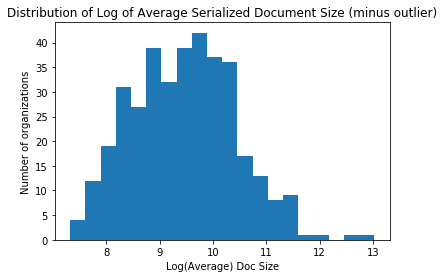

In [14]:
#Distribution is highly skewed, so replot with log transform
plt.hist(np.log(filtered['doc_size.avg']), bins=20)
plt.title("Distribution of Log of Average Serialized Document Size (minus outlier)")
plt.xlabel("Log(Average) Doc Size")
plt.ylabel("Number of organizations")
plt.show()

Based on this distribution, orgs with a log(average doc size) between 8 and 9.5 represent the majority of results that are likely to be the most useful to our end users.  Having identified these bounds, we can incorporate them into our utility score definition.

In [15]:
def calculate_utility(org):
    """
    -20 if log(record size) is less than 8
    -20 if log(record size) is more than 9.5
    (numbers above are based on the overall distribution)
   
    For records between the thresholds above
    -2 per percentage point over 70 for financial
    -1 per percentage point under 30 for program
   
    For everyone
    -20 for title/description perfectly aligned
    -10 for title/description perfectly misaligned
    """
   
    score=100
    #First two criteria
    if np.log(org['doc_size']['avg'])<8:
        score-=30
    elif np.log(org['doc_size']['avg'])>9.5:
        score-=30
       
    #Second two criteria
    else:
        #Financial
        if org['relative_size'] is None:
            return 0
        rel_sz=org['relative_size']
        if rel_sz['budget'] is None or rel_sz['transaction'] is None:
            return 0
        raw_financial_result=(org['relative_size']['budget']+
                              org['relative_size']['transaction']*2-
                              0.7)
       
        if raw_financial_result>0:
            score-=(raw_financial_result*100) #convert to percentage
       
        #Program
        raw_program_result=0.3-(org['relative_size']['description']+
                            org['relative_size']['document-link']+
                            org['relative_size']['participating-org']+
                            org['relative_size']['result']+
                            org['relative_size']['title']
                           )
        if raw_program_result>0:
            score-=(raw_program_result*100) #convert to percentage
           
    #Third two criteria
    if (org['title_description_similarity'] or 0)<0.2:
        # title not related to description
        score-=10
    elif (org['title_description_similarity'] or 0)>0.7:
        # title and description basically the same
        score-=20
    return int(score)

calculate_utility(test)

60

In [16]:
def find_distance(a,b,c):
    """
    Similar to CN calculation - calculate 3D euclidean distance from perfect score
    http://www.charitynavigator.org/index.cfm?bay=content.view&cpid=1287
    """
    #print a,b,c
    return np.sqrt((a**2+b**2+c**2)/3)

In [17]:
def calculate_score(org):
    """
    Calculate all scores and output json result
    This will enable us to load the output into mongo or (with one extra step) pandas
    """
    completeness=calculate_completeness(org)
    compliance=calculate_compliance(org)
    utility=calculate_utility(org)
    distance=round(float(find_distance(completeness,compliance,utility)),1)
    return {"organization_id":org['organization_id'],
            "completeness":completeness,"compliance":compliance,
            "utility":utility,"distance":distance}

calculate_score(test)

{'completeness': 79,
 'compliance': 41,
 'distance': 62.0,
 'organization_id': '21032',
 'utility': 60}

### Calculate scores for all orgs and explore results

In [18]:
#Calculate scores iteratively based on mongo input
scores=[]
for org in orgs.find():
    scores.append(calculate_score(org))

#Convert results to dataframe for easier EDA
scores_df=json_normalize(scores)
full_results=df.join(scores_df,rsuffix='_DUPLICATE')

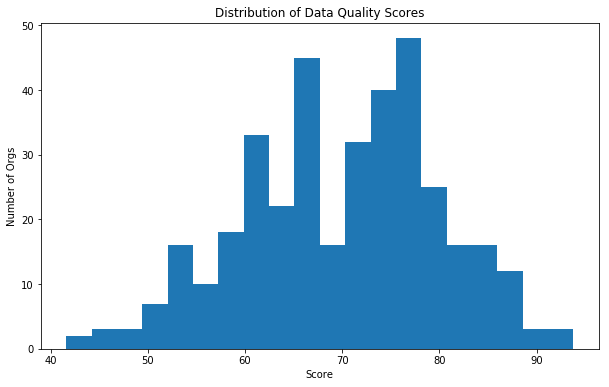

In [19]:
#Plot distribution
plt.figure(figsize=(10,6))
plt.hist(full_results['distance'],bins=20)
plt.title("Distribution of Data Quality Scores")
plt.xlabel("Score")
plt.ylabel("Number of Orgs")
plt.show()

In [20]:
#Rebuild raw data for histogram so we can export it and add to the site
bins=np.linspace(40,100,21)
hist_data=np.histogram(full_results['distance'], bins=bins)
print(hist_data)
benchmark_output=pd.DataFrame(hist_data[0],hist_data[1][:-1])
benchmark_output.to_csv('benchmark_data.csv')

(array([ 2,  0,  5,  8, 17, 17, 20, 30, 54, 20, 34, 46, 45, 29, 17, 18,  5,
        3,  0,  0]), array([  40.,   43.,   46.,   49.,   52.,   55.,   58.,   61.,   64.,
         67.,   70.,   73.,   76.,   79.,   82.,   85.,   88.,   91.,
         94.,   97.,  100.]))


Based on this tuning of the model, we can reasonably assign letter grades in line with typical breakdowns (A=100-90,B=89-80,C=79-70,D=69-60,F=<59)

In [21]:
def get_letter_grade(row):
    score=row['distance']
    if score>=90:
        grade='A'
    elif 80<=score<90:
        grade='B'
    elif 70<=score<80:
        grade='C'
    elif 60<=score<70:
        grade='D'
    else:
        grade='F'
    return grade

In [22]:
#Calculate grades
full_results['grade']=full_results.apply(get_letter_grade,axis=1)

Text(0,0.5,'Percentage')

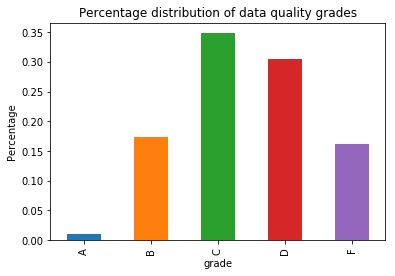

In [23]:
grades = full_results.groupby('grade')
grade_results=grades.size()
grade_percents=grade_results/sum(grade_results)
percent_plot=grade_percents.plot(kind='bar', title="Percentage distribution of data quality grades")
percent_plot.set_ylabel("Percentage")

In [24]:
grade_results
grade_percents

grade
A    0.010811
B    0.172973
C    0.348649
D    0.305405
F    0.162162
dtype: float64

# Final Cleanup and Export

In [25]:
#add "other" column for relative size to make visualizing easier
filter_col = [col for col in list(full_results) if col.startswith('relative')]
full_results['relative_size.other']=1-full_results[filter_col].sum(axis=1)

#add percentile rank for benchmarking
full_results['percentile_rank']=full_results['distance'].rank(pct=True)

In [26]:
#Drop duplicate organization_id
full_results.drop('organization_id_DUPLICATE', axis=1, inplace=True)

In [27]:
#Format columns nicely for future Flask integration
rename_dict={}
for column in list(full_results.columns):
    new=column.replace('.','_')
    new=new.replace('-','_')
    rename_dict[column]=new
   
rename_dict['missing_data.@xml:lang']='missing_data_language'
rename_dict['missing_data.@default_currency']='missing_data_currency'
full_results.rename(columns=rename_dict,inplace=True)

rename_dict['missing_data_@default_currency']='missing_data_currency'
full_results.rename(columns=rename_dict,inplace=True)

In [28]:
full_results[full_results['organization_id']=='21032'].transpose()

,363
_id,5a4950b46f8487050240e253
benford_compliance_budget,0.269231
benford_compliance_budget_distribution_0,0.591716
benford_compliance_budget_distribution_1,26.9231
benford_compliance_budget_distribution_2,18.3432
benford_compliance_budget_distribution_3,12.7219
benford_compliance_budget_distribution_4,10.9467
benford_compliance_budget_distribution_5,8.87574
benford_compliance_budget_distribution_6,6.50888
benford_compliance_budget_distribution_7,5.91716


In [29]:
#Drop _id column (since it breaks encoding) and encode to flat JSON
full_results.iloc[:, full_results.columns != '_id'].to_json('test_scores.json',orient='records')

In [30]:
#Reload and check records
import io, json
with io.open('test_scores.json', encoding='utf-8') as f:
    records=json.load(f)

test=records[0]
test

{'benford_compliance_budget': 0.5,
 'benford_compliance_budget_distribution_0': 0.0,
 'benford_compliance_budget_distribution_1': 50.0,
 'benford_compliance_budget_distribution_2': 12.5,
 'benford_compliance_budget_distribution_3': 0.0,
 'benford_compliance_budget_distribution_4': 0.0,
 'benford_compliance_budget_distribution_5': 0.0,
 'benford_compliance_budget_distribution_6': 12.5,
 'benford_compliance_budget_distribution_7': 25.0,
 'benford_compliance_budget_distribution_8': 0.0,
 'benford_compliance_budget_distribution_9': 0.0,
 'benford_compliance_transaction': 1.0,
 'benford_compliance_transaction_distribution_0': 0.0,
 'benford_compliance_transaction_distribution_1': 41.77,
 'benford_compliance_transaction_distribution_2': 36.7733333333,
 'benford_compliance_transaction_distribution_3': 4.4433333333,
 'benford_compliance_transaction_distribution_4': 0.0,
 'benford_compliance_transaction_distribution_5': 2.6733333333,
 'benford_compliance_transaction_distribution_6': 2.223333333

In [31]:
# save the scores to the database
db.drop_collection('scores')
db.scores.insert_many(records)
db.scores.count()

370

# Imputing missing data (where possible)

In [32]:
#load graph structure into memory
#note that this is currently using the text file, but for consistency we should use the pickled version

with open('graph_root_ref.txt', 'rb') as myfile:
    graph_df=pd.DataFrame(pickle.load(myfile))
graph_df=graph_df.drop(graph_df.columns[0], axis=1)
graph_df.columns=['source','sink']

In [33]:
#Load activity text
t0 = time()
orgs_ids = set()
with open('iati_text.txt', 'r') as myfile:
    lines = myfile.readlines()
    print(len(lines))
    for line in lines:
        line = line.split('\t')
        orgs_ids.add(line[0])
print('Number of orgs reporting ' + str(len(orgs_ids)))
print(time() - t0)

732034
Number of orgs reporting 381
3.1776037216186523


In [34]:
nltk.download('words')

[nltk_data] Downloading package words to /home/jupyter/nltk_data...
[nltk_data]   Unzipping corpora/words.zip.


True

In [35]:
#Create bag-of-words
t0 = time()
corpus = set(words.words()) #create corpus to use

cur_line = 0
orgs_with_text = {} #dictionary to hold org ids as keys and a list of all text as a value
with open('iati_text.txt', 'r') as infile: #open infile
    lines = infile.readlines()
    for line in lines: #for each line of text in iati text
        if cur_line % 50000 == 0: #sanity check
            print('Completed ' + str(cur_line) + ' lines')
        cur_id, data = line.split('\t') #split line
        working = orgs_with_text.get(cur_id) #retrieve value
        if working is None: #if this doesn't exist then initialize a key and an empty list
            orgs_with_text[cur_id] = []
            working = []
        for word in data.split(): #split into word tokens
            if word.lower() in corpus: #check if word in corpus
                working.append(word.lower()) #add to list
        orgs_with_text[cur_id] = working #update dictionary value
        cur_line += 1

print(len(orgs_with_text.keys()))
print('time: ' + str(time() - t0))

Completed 0 lines
Completed 50000 lines
Completed 100000 lines
Completed 150000 lines
Completed 200000 lines
Completed 250000 lines
Completed 300000 lines
Completed 350000 lines
Completed 400000 lines
Completed 450000 lines
Completed 500000 lines
Completed 550000 lines
Completed 600000 lines
Completed 650000 lines
Completed 700000 lines
381
time: 63.75599765777588


In [36]:
#Convert Bag-of-words into matrix via TFIDF vectorizer

t0 = time()
raw_text = [] #holder for all text, these are words in the corpus
for doc in orgs_with_text.values():
    new_doc = str(doc) #render as a string
    raw_text.append(new_doc)

vectorizer = TfidfVectorizer(stop_words = 'english') #create vectorizer
tf_matrix = vectorizer.fit_transform(raw_text)

print('vectorized in ' + str(time() - t0))
print(tf_matrix.shape)

vectorized in 51.873862981796265
(381, 23797)


In [37]:
orgs_with_text_keys = [x for x in orgs_with_text.keys()]

In [38]:
#Returns the nearest neighbors as sorted by cosine similarity
def getSimilarity(org_id):
    num = None
    for i, key in enumerate(orgs_with_text_keys):
        if org_id == key: #match id
            num = i #return number corresponding to row in matrix
            break

    similarity_matrix = cosine_similarity(tf_matrix[num], tf_matrix) #get cosine similarity
    sorted_matrix = np.argsort(similarity_matrix[0]) #sort and get ids
    nums = list(sorted_matrix[-6:])[::-1][1:] #render top number as list and reverse order (most similar is first)
    print(nums)
    #in above line reverse and then remove first item which is the same ID
    to_return = []
    for num in nums: #take numeric placeholders and translate into ids
        to_return.append(orgs_with_text_keys[num])
    return to_return

In [39]:
nums = getSimilarity('NL-KVK-52957535')
print(nums)

[371, 296, 127, 50, 97]
['ZA-CIPC-2001/005850/08', 'GB-CHC-294329', 'NL-KVK-41198677', 'NL-KVK-41210098', 'XM-DAC-411124']


In [40]:
def get_neighbors(organization_id):
    """returns a sorted dataframe with all neighbors for a given org"""
    aggregate=graph_df[graph_df['source']==organization_id].groupby('sink').count()
    return aggregate.sort_values("source",ascending=False)

def find_missing(record):
    """check if a record is missing values"""
    fields_to_fill = [] #holder to contain fields we will try to impute
    for mis in record.keys(): #check all missing fields
        if record[mis] != 0 and 'missing_data_' in mis:
            fields_to_fill.append(mis)
    return fields_to_fill


def find_imputing_options(cur_record):
    """impute all possible fields for a given record (this is the entire record, not just the id)"""

    impute_results={}
    missing_fields = find_missing(cur_record) #get the missing fields for that record
    neighbors = get_neighbors(cur_record['organization_id']) #get a list of neighbors for each record
   
    for field in missing_fields: #check each field that is missing
        for neighbor in neighbors.iterrows(): #check each neighbor, starting with the closest
            cur_neighbor = db.scores.find_one({'organization_id':neighbor[0]}) #get record of the neighbor
            if cur_neighbor: #if the record exists proceed
                neighbor_missing = find_missing(cur_neighbor) #get the fields that are missing for the neighbor
                if field not in neighbor_missing: #if a neighbor is not missing the same field we can impute
                    #print('can impute ' + str(field[13:]) + ' for ' + str(cur_record['organization_id']) + ' from ' + str(neighbor[0]))
                    try:
                        text_neighbors=getSimilarity(neighbor[0])
                    except IndexError:
                        text_neighbors=[]
                    similar=0
                    if neighbor[0] in text_neighbors:
                        similar=1
                   
                    impute_results[field[13:]]={'organization_id':neighbor[0],'similar_text':similar,'grade':cur_neighbor['grade']}
                    break
    return impute_results

In [41]:
#Run through the collection and add imputed records
updated=0
similar=0
for k,i in enumerate(db.scores.find()):
    results=find_imputing_options(i)
    #print(results)
    db.scores.update_one({"organization_id": i['organization_id']},{"$set": {"impute_options": results}})
    if results:
        for j in results.items():
            if j[1]['similar_text']==1:
                similar+=1
                break
        updated+=1
    if k %20==0:
        print(datetime.now(), k,updated,similar)
print(datetime.now(), k,updated)

2017-12-31 23:37:39.191586 0 0 0
[17, 181, 4, 12, 82]
[17, 181, 4, 12, 82]
[17, 181, 4, 12, 82]
[17, 181, 4, 12, 82]
[265, 151, 8, 70, 135]
[17, 181, 4, 12, 82]
2017-12-31 23:37:42.019824 20 3 0
[17, 181, 4, 12, 82]
[17, 181, 4, 12, 82]
[178, 84, 7, 327, 247]
[60, 135, 8, 190, 296]
[16, 158, 299, 31, 367]
[17, 181, 4, 12, 82]
[307, 43, 114, 326, 31]
[191, 267, 247, 163, 8]
[65, 37, 144, 285, 192]
[65, 37, 144, 285, 192]
[307, 43, 114, 326, 31]
2017-12-31 23:37:44.444034 40 9 0
[50, 313, 247, 270, 120]
[4, 137, 37, 12, 17]
[17, 181, 4, 12, 82]
[228, 326, 114, 200, 285]
[228, 326, 114, 200, 285]
[228, 326, 114, 200, 285]
[17, 181, 4, 12, 82]
[17, 181, 4, 12, 82]
[97, 285, 212, 247, 161]
2017-12-31 23:37:46.948516 60 13 0
[178, 84, 7, 327, 247]
[178, 84, 7, 327, 247]
[4, 137, 37, 12, 17]
[178, 84, 7, 327, 247]
[307, 43, 114, 326, 31]
[17, 181, 4, 12, 82]
[307, 43, 114, 326, 31]
2017-12-31 23:37:49.487532 80 15 0
[17, 181, 4, 12, 82]
[17, 181, 4, 12, 82]
[191, 267, 247, 163, 8]
[65, 37, 14

In [42]:
for i in db.scores.find():
    if i["impute_options"]:
        print(i['organization_id'])
        break

US-EIN-46-3668128


In [43]:
test=db.scores.find_one({'organization_id': {'$eq': 'NL-KVK-51018586'}},{'_id':False})

In [44]:
for i in test['impute_options'].items():
    print(i)

('budget', {'organization_id': '41120', 'similar_text': 0, 'grade': 'B'})
('document_link', {'organization_id': 'NL-KVK-27327087', 'similar_text': 0, 'grade': 'C'})
('result', {'organization_id': 'NL-KVK-27327087', 'similar_text': 0, 'grade': 'C'})
